I start by importing python libraries numpy,pandas ... that I will need in this code and then I used sklearn to get the data from the datasets, In fact I will do clustring to 7 classes of the data by using the algorithm of UMAP merged by some intuitions of the  T-SNE algorithm.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import SpectralEmbedding
from time import time
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
             discriminant_analysis, random_projection)
digits = datasets.load_digits(n_class=7)
X_train = digits.data
print(X_train.shape)
print(X_train)
y_train = digits.target
print(y_train)
n = X_train.shape[0]
print(X_train.shape, y_train.shape)

(1264, 64)
[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  0. ...  9.  0.  0.]
 [ 0.  0.  0. ...  4.  0.  0.]
 [ 0.  0.  6. ...  6.  0.  0.]]
[0 1 2 ... 4 4 0]
(1264, 64) (1264,)


The two lines of code below are to calculate the Euclidean distance matrix of all the digits and for each Digit corresponding to a row in the Euclidien distance matrix, I will calculate the distances between this digit and all the other digits then I will sort this distances to find the nearest neighbor to the actual digit that we will call RHOO  

In [17]:
DISTANCE = np.square(euclidean_distances(X_train, X_train)) 

RHOO = [sorted(DISTANCE[i])[1] for i in range(DISTANCE.shape[0])]


In [18]:
def  Proba_High_dimension(SIGMA, ROW_DIST):
    """
    For each row in the Euclidean distance matrix I will compute the probability in high dimensions.
    For the row ROW_DIST,  I will get 1 Dimension array that represent the probability that one digit from 
    the ones that we have is near to the digit that correspond to the row ROW_DIST.
    
    """
    D = DISTANCE[ROW_DIST] - RHOO[ROW_DIST]; D[D < 0] = 0
    return np.exp(- D / SIGMA)

def CALCULATE_k(PROB):
    """
    for each 1D array of high-dimensional probability I will compute the numbre of neighbors k 
    of one digit corresponding to this 1D array.    
    
    """
    return np.power(2, np.sum(PROB))

In [19]:
def SIGMA_BINARY_SEARCH(Researshed_k , fixed_k):
    """
    In this function I will calculate the SIGMA corresponding to each row in the Euclidean distance matrix, 
    In Fact, for each row I will solve the equation Researshed_k(sigma) = fixed_k  to find the approximate-sigma 
    corresponding to the digit of this row by using the binary search algorithm
    
    """
    sigma_lower_limit = 0; sigma_upper_limit = 1000
    for i in range(25):
        approx_sigma = (sigma_lower_limit + sigma_upper_limit) / 2
        if Researshed_k(approx_sigma) < fixed_k:
            sigma_lower_limit = approx_sigma
        else:
            sigma_upper_limit = approx_sigma
        if np.abs(fixed_k - Researshed_k(approx_sigma)) <= 1e-7:
            break
    return approx_sigma

N_NEIGHBOR = 20
"I will use this value of N_NEIGHBOR like a parameter when I will run the original UMAP function "
"By this boucle  I will construct the matrix of probabilities in high dimensionnal Embedding Space and I will have for each row one value of sigma  "
PROB = np.zeros((n,n)); sigma_array = []
for i in range(n):
    haf = lambda SIGMA: CALCULATE_k(Proba_High_dimension(SIGMA, i))
    The_right_Sigma = SIGMA_BINARY_SEARCH(haf, N_NEIGHBOR)
    PROB[i] = Proba_High_dimension(The_right_Sigma, i)
    sigma_array.append(The_right_Sigma )
print("\nMean sigma = " + str(np.mean(sigma_array)))


Mean sigma = 89.39239401606065


Normally the original algorithm of UMAP uses the  symmetrization in the first line of code for me I have tried another way of symmetrization like the second line show because by experience I pointing out better visualisation. Moroever, I tried to divide the PROB + np.transpose(PROB) by other values other than 2 but the better visualisation of the data in low Dimension Embidding is given by the value 2

In [20]:
#P = PROB + np.transpose(PROB) - np.multiply(PROB, np.transpose(PROB)
P = (PROB + np.transpose(PROB))/ 2


Here I have choosen the values of a and b equal to one to merge the logic of the UMAP algorithm with T-SNE algorithm that use this values to compute the matrix of probabilities q_ij in low-dimensional space


In [21]:
MIN_DIST = 0.20
a= 1
b= 1

def PROBABILITE_MATRICE_LOW(Y):
    
    INVERSE_DISTANCE = np.power(1 + a * np.square(euclidean_distances(Y, Y))**b, -1)
    return INVERSE_DISTANCE

Now I will compute the Cross-Entropy (CE) of the UMAP algorithm from matrix of high-dimensional probabilities  and coordinates of low-dimensional embeddings then I will Compute the gradient of Cross-Entropy (CE) by applying one idea of the T-SNE algorithm that is the normalisation of the matrice probability in low dimension.    


In [22]:
def CrossEntropy(P, Y):
    
    Q = PROBABILITE_MATRICE_LOW(Y)
    return - P * np.log(Q+ 0.01) - (1 - P) * np.log(1 - Q + 0.01)

def CrossEntropy_gradient(P, Y):
   
    Y_difference = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)
    inverse_distance = np.power(1 + a * np.square(euclidean_distances(Y, Y))**b, -1)
    Q = np.dot(1 - P, np.power(0.001 + np.square(euclidean_distances(Y, Y)), -1))
    np.fill_diagonal(Q, 0)
    Q = Q / np.sum(Q, axis = 1, keepdims = True)
    Fact=np.expand_dims(a*P*(1e-6+ np.square(euclidean_distances(Y, Y)))**(b-1) - Q, 2)
    return 2 * b * np.sum(Fact * Y_difference * np.expand_dims(inverse_distance, 2), axis = 1)

Unlike the optimization of the T-SNE algorithm which uses the gradient descent to optimize the cost function and the UMAP which uses the stochastic gradient descent, I chose to work here with a  batch gradient descent method.
Therefore, I tried to apply the course material here by adapting the learning_rate to the variation of the gradient function. I have tried this methode of adapting the learning rate and it looks efficient in the visualisation of data in low-dimentional Embedding comparing to the original UMAP that you find under this code ."

In [47]:
N_LOWER_DIMS = 2
LEARNING_RATE = 1
MAX_ITER = 150
np.random.seed(12345)
model = SpectralEmbedding(n_components = N_LOWER_DIMS, n_neighbors = 20)
y = model.fit_transform(np.log(X_train[:,1:5]+1))

LR_array = [1,]
print("Running Gradient Descent: \n")
for i in range(MAX_ITER):
    y = y - LEARNING_RATE * CrossEntropy_gradient(P, y)
    
    LR_array.append(LEARNING_RATE / (i+1))
   
    LEARNING_RATE=4*np.mean(LR_array)
    
    if i % 10 == 0:
        print("LEARNING_RATE = " + str(LEARNING_RATE) + " after " + str(i) + " iterations")



/home/user/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Running Gradient Descent: 

LEARNING_RATE = 4.0 after 0 iterations
LEARNING_RATE = 4.020366905946689 after 10 iterations
LEARNING_RATE = 2.5737728574636134 after 20 iterations
LEARNING_RATE = 1.8767413913491273 after 30 iterations
LEARNING_RATE = 1.474247911080742 after 40 iterations
LEARNING_RATE = 1.2132097437547735 after 50 iterations
LEARNING_RATE = 1.0304535626237785 after 60 iterations
LEARNING_RATE = 0.8954393667847508 after 70 iterations
LEARNING_RATE = 0.7916528851394383 after 80 iterations
LEARNING_RATE = 0.7093974674135086 after 90 iterations
LEARNING_RATE = 0.6426097820845029 after 100 iterations
LEARNING_RATE = 0.5873056214680759 after 110 iterations
LEARNING_RATE = 0.5407598596977177 after 120 iterations
LEARNING_RATE = 0.5010458564360527 after 130 iterations
LEARNING_RATE = 0.4667631385541308 after 140 iterations


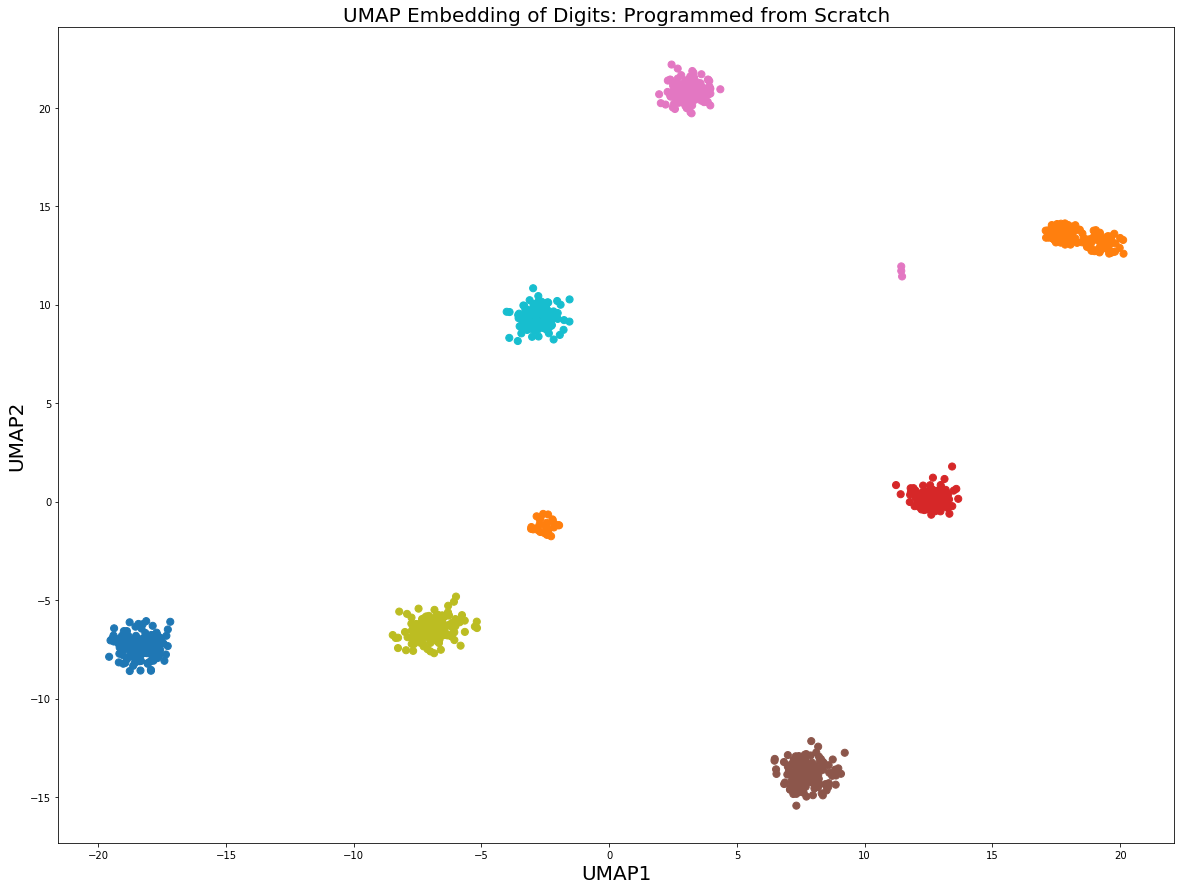

In [48]:
plt.figure(figsize=(20,15))
plt.scatter(y[:,0], y[:,1], c = y_train.astype(int), cmap = 'tab10', s = 50)
plt.title("UMAP Embedding of Digits: Programmed from Scratch", 
          fontsize = 20)
plt.xlabel("UMAP1", fontsize = 20); plt.ylabel("UMAP2", fontsize = 20)
plt.show()

To compare this algorithm UMAP merged with some intuitions from T_SNE and the original UMAP function 
I will preserve the same parameters that I worked on before like  n_neighbors = 20 and min_dist = 0.20 and I will run the original UMAP on the X_train data

/home/user/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.2, n_components=2, n_epochs=None,
     n_neighbors=20, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=None, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Sun Mar  8 15:40:08 2020 Finding Nearest Neighbors
Sun Mar  8 15:40:08 2020 Finished Nearest Neighbor Search
Sun Mar  8 15:40:08 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed

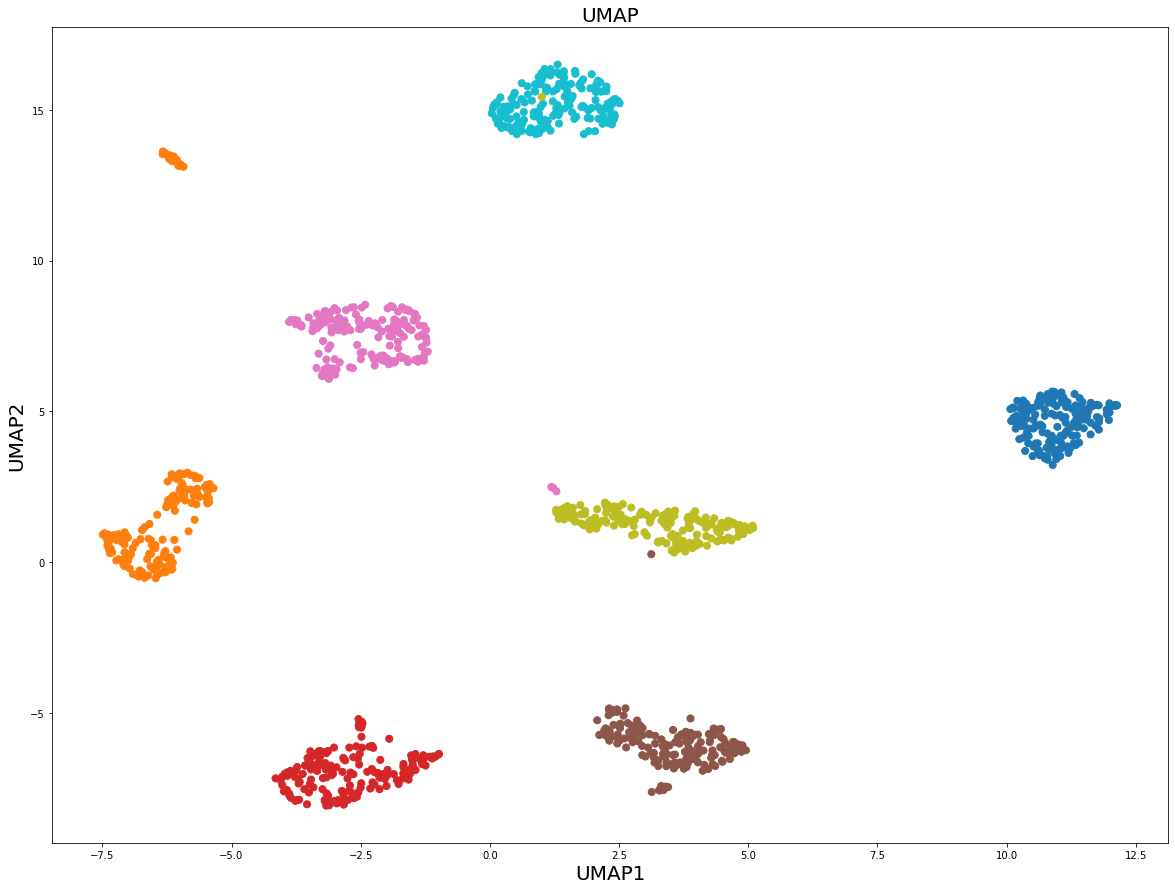

In [49]:
from umap import UMAP
plt.figure(figsize=(20,15))
model = UMAP(n_neighbors = 20, min_dist = 0.20, n_components = 2, verbose = True)
umap = model.fit_transform(X_train)
plt.scatter(umap[:, 0], umap[:, 1], c = y_train.astype(int), cmap = 'tab10', s = 50)
plt.title('UMAP', fontsize = 20)
plt.xlabel("UMAP1", fontsize = 20)
plt.ylabel("UMAP2", fontsize = 20)
plt.show()